### Importing 

In [363]:
import sqlite3
import requests
import re
from bs4 import BeautifulSoup, Comment
import json
import pandas as pd
import time
import folium
import matplotlib.pyplot as plt
import urllib.request
from selenium import webdriver
import random
import xgboost as xg
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import traceback

import gensim, logging, warnings
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [364]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

In [365]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #WBOT
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn import neighbors
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #these three are for visualization
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist 
from nltk import pos_tag  
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from matplotlib import cm
import numpy as np




import string, re
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GMoneyMan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GMoneyMan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GMoneyMan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [366]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

### Cleaning the Dataframe

In [367]:
#read in the csv
beer_df = pd.read_csv(r'C:\Users\GMoneyMan\Documents\Flatiron\capstone\csv_data\beer_w_reviews.csv')

In [368]:
beer_df

,beer_style,beer_name,brewery_name,abv,no_ratings,avg_rating,drop_me,url,review
0,Fruit and Field,#9,Magic Hat Brewing Company,5.10,"5,915",3.42,NaN,https://www.beeradvocate.com/beer/profile/96/299/,"[""Elemental19xx from Illinois3.6/5\xa0\xa0rDev..."
1,Fruit and Field,Samuel Adams Cherry Wheat,Boston Beer Company (Samuel Adams),5.30,"4,029",3.19,NaN,https://www.beeradvocate.com/beer/profile/35/108/,['BergBeer from Virginia1.15/5\xa0\xa0rDev -63...
2,Fruit and Field,Raspberry Tart,New Glarus Brewing Company,4.00,"3,992",4.41,NaN,https://www.beeradvocate.com/beer/profile/590/...,"[""TedHead from Illinois4.85/5\xa0\xa0rDev +10%..."
3,Fruit and Field,Summer Shandy,Jacob Leinenkugel Brewing Company,4.20,"3,841",3.20,NaN,https://www.beeradvocate.com/beer/profile/710/...,['AlCaponeJunior from Texas2.79/5\xa0\xa0rDev ...
4,Fruit and Field,Rübæus,Founders Brewing Company,5.70,"3,799",3.91,NaN,https://www.beeradvocate.com/beer/profile/1199...,['TomQBigBeerGuy from Michigan3.88/5\xa0\xa0rD...
...,...,...,...,...,...,...,...,...,...
7339,Fruit and Field,Radler,Occy's Brewery,4.80,0,0.00,NaN,https://www.beeradvocate.com/beer/profile/2128...,NaN
7340,Fruit and Field,Alan-A-Dale Apple Ale,Robin Hood Brewing Co. / Home D Pizzeria,5.00,0,0.00,NaN,https://www.beeradvocate.com/beer/profile/4182...,NaN
7341,Fruit and Field,Tussle In the Hay,Back Unturned Brewing Company,7.90,0,0.00,NaN,https://www.beeradvocate.com/beer/profile/5844...,NaN
7342,Fruit and Field,Strawberry Chocolate Cheesecake Sour,Barn Town Brewing,5.90,0,0.00,NaN,https://www.beeradvocate.com/beer/profile/4760...,NaN


>We have a column that is completely empty for everything that I have labeled as "drop_me". There are also NaN values for empty reviews. So we drop those as well. We want to have no observations with null values

In [369]:
#check if there are any NaN values
beer_df.isna().sum()

beer_style         0
beer_name          0
brewery_name       0
abv              144
no_ratings       144
avg_rating       144
drop_me         7344
url              144
review          1799
dtype: int64

In [370]:
#dropping the column that has no data
beer_df.drop('drop_me', axis = 1, inplace = True)

In [371]:
#dropping the rows that have no reviews
beer_df.dropna(subset=['review'], inplace = True)

In [372]:
#checking if there are any reviewed beers without ratings
empty_rating = beer_df[beer_df['no_ratings'] == 0]

In [373]:
#turn this column from str to float
beer_df['no_ratings'] = beer_df['no_ratings'].str.replace(',', '').astype(float)

In [374]:
#dropping the columns without ratings
beer_df.drop(empty_rating.index, inplace = True)

### Cleaning the Reviews w/ Stopwords

In [375]:
#stopwords and punctuation
stop_words = stopwords.words('english')
beer_stop = ['look', 'smell', 'taste', 'feel', 'overall', 'rdev', 'beer', 'beers', 'like', 'nice','adams', 'jan', 'feb', 'mar',
                  'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'canada', 'north']
stop_words += string.punctuation

>Every review has a scorecard for "look, smell, taste, feel, and overall" as well as "rdev" for the standard dev from the mean score. Words like "like, beer, and nice" were also cut as they were very common words that didn't add much. "canada and north" are taken out since they are unrelated to the beers and two reviews had those words as the only words in their review.

### Lemmatization

>End up sticking with Lemmatization as it gives better results

In [376]:
# A function that will apply stop words, remove numbers, punctuation, and normalization to a body of text
def pre_process_text(text):
    stop = set(stopwords.words('english'))
    stop |= set(beer_stop)
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    def clean(doc):
        if doc is not None:
            stop_free = " ".join([i for i in doc.lower().split() if i not in stop and i.isalpha()])
            punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
            normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
            return normalized
        else:
            pass
    processed_text = clean(text)
    if processed_text is not None:
        return processed_text.split()

>This function will establish the stopwords with the lemmatizer and return the processed text.

In [377]:
#takes in a dataframe with a column with raw text and outputs a new column with pre-processed text
def add_processed_text(df, output_column_name, column_to_target='review'):
    df[output_column_name] = df.apply(lambda row: pre_process_text(row[column_to_target]), axis=1)

>This will process the text through the previous function and create a new column for it. Here using the lem function

In [378]:
def count_word_frequency(vectorizer, text):
    try:
        termFrequencyMatrix = vectorizer.fit_transform(text)
        return termFrequencyMatrix
    except:
        print('Problem in count word freq')
        print(traceback.format_exc())

>This will vectorize the words that are passed through

In [379]:
#runs a vectorizer over a row of the target column and if empty it will pass. Afterwards it will 
#generate a new column with the term frequency matrix
def get_term_freq_matrices(vectorizer, df, target_column):
    df['tf_matrix'] = df.apply(lambda row: count_word_frequency(vectorizer, row[target_column]) if
    row[target_column] != None else None, axis=1)

>This function will use the previous function to create a column using a previous column

In [380]:
#runs the processor over the review column and creates a new one with the results
add_processed_text(beer_df, 'clean_reviews', column_to_target='review')

>Here we are creating our column of "clean_reviews" from the normalized text

In [381]:
#runs the vectorizer over the df and column we just created with the processed text
#tfidf = TfidfVectorizer()
#get_term_freq_matrices(tfidf, beer_df, 'clean_reviews')

In [382]:
#creates a column that breaks the text out of a list and into a str
beer_df['naked_reviews'] = beer_df.apply(lambda row: ' '.join(row['clean_reviews']), axis =1)

>This is for a row from 'clean_reviews' that will be broken out of the list shell it is in in case it is needed.

### Stemming

In [ ]:
def pre_process_text_stem(text):
    stop = set(stopwords.words('english'))
    stop |= set(beer_stop)
    exclude = set(string.punctuation)
    stemm = PorterStemmer()
    def clean(doc):
        if doc is not None:
            stop_free = " ".join([i for i in doc.lower().split() if i not in stop and i.isalpha()])
            punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
            normalized = " ".join(stemm.stem(word) for word in punc_free.split())
            return normalized
        else:
            pass
    processed_text = clean(text)
    if processed_text is not None:
        return processed_text.split()

>This function will establish the stopwords with the stemmer and return the processed text.

In [ ]:
def add_processed_text_stem(df, output_column_name, column_to_target='review'):
    df[output_column_name] = df.apply(lambda row: pre_process_text_stem(row[column_to_target]), axis=1)

>This will process the text through the previous function and create a new column for it. Here using the stem function

In [ ]:
add_processed_text_stem(beer_df, 'clean_reviews_stem', column_to_target='review')

>Here we are creating our column of "clean_reviews" from the normalized text (stem)

In [ ]:
beer_df['naked_reviews_stem'] = beer_df.apply(lambda row: ' '.join(row['clean_reviews_stem']), axis =1)

>This is for a row from 'clean_reviews' that will be broken out of the list shell it is in in case it is needed.

### Post Tokanization / Lemmatization / Stemming

>Eventually we go with the Lemmatization since we get better results when passing it through the models

In [84]:
beer_df

,beer_style,beer_name,brewery_name,abv,no_ratings,avg_rating,url,review,clean_reviews,naked_reviews,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,Fruit and Field,#9,Magic Hat Brewing Company,5.10,5915.0,3.42,https://www.beeradvocate.com/beer/profile/96/299/,"[""Elemental19xx from Illinois3.6/5\xa0\xa0rDev...","[pours, little, cloudy, little, small, smell, ...",pours little cloudy little small smell fruity ...,4431,684,684,1,6.478070,684.0
1,Fruit and Field,Samuel Adams Cherry Wheat,Boston Beer Company (Samuel Adams),5.30,4029.0,3.19,https://www.beeradvocate.com/beer/profile/35/108/,['BergBeer from Virginia1.15/5\xa0\xa0rDev -63...,"[bottle, shaker, pint, hazy, copper, thick, wh...",bottle shaker pint hazy copper thick white che...,4744,726,726,1,6.534435,726.0
2,Fruit and Field,Raspberry Tart,New Glarus Brewing Company,4.00,3992.0,4.41,https://www.beeradvocate.com/beer/profile/590/...,"[""TedHead from Illinois4.85/5\xa0\xa0rDev +10%...","[beautiful, ruby, red, head, dissipates, smell...",beautiful ruby red head dissipates smell inten...,7169,1038,1038,1,6.906551,1038.0
3,Fruit and Field,Summer Shandy,Jacob Leinenkugel Brewing Company,4.20,3841.0,3.20,https://www.beeradvocate.com/beer/profile/710/...,['AlCaponeJunior from Texas2.79/5\xa0\xa0rDev ...,"[one, favorite, summer, smell, taste, bit, res...",one favorite summer smell taste bit rest area ...,6111,916,916,1,6.671397,916.0
4,Fruit and Field,Rübæus,Founders Brewing Company,5.70,3799.0,3.91,https://www.beeradvocate.com/beer/profile/1199...,['TomQBigBeerGuy from Michigan3.88/5\xa0\xa0rD...,"[pour, pink, raspberry, impressive, white, hea...",pour pink raspberry impressive white head ligh...,5521,817,817,1,6.757650,817.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,Fruit and Field,Crécelle Rouge,Brasserie Artisanale De La Crécelle,5.00,1.0,3.53,https://www.beeradvocate.com/beer/profile/1884...,['thierrynantes from France3.53/5\xa0\xa0rDev ...,"[bottle, purchased, la, crécelle, brewery, tas...",bottle purchased la crécelle brewery tasted sl...,237,33,33,1,7.181818,33.0
5638,Fruit and Field,Blood Orange Radler,Flyway Brewing Company,4.50,1.0,3.75,https://www.beeradvocate.com/beer/profile/4570...,['jvgoor3786 from Arkansas3.75/5\xa0\xa0rDev 0...,"[bright, color, fizzy, white, ton, blood, oran...",bright color fizzy white ton blood orange foll...,104,16,16,1,6.500000,16.0
5639,Fruit and Field,Mos'ka Garnatxa Beer,Cerveseria Birrart,6.00,1.0,3.67,https://www.beeradvocate.com/beer/profile/1953...,['GONZALOYANNA from Spain3.67/5\xa0\xa0rDev 0%...,"[timmermans, flute, enjoyed, reddish, amber, f...",timmermans flute enjoyed reddish amber foggy f...,426,60,60,1,7.100000,60.0
5648,Fruit and Field,Rainier Raspberry Wheat,Harmon Restaurant & Brewery,?,1.0,2.60,https://www.beeradvocate.com/beer/profile/1386...,['barleywinefiend from Washington2.6/5\xa0\xa0...,"[poured, cloudy, straw, color, almost, head, w...",poured cloudy straw color almost head white ma...,108,16,16,1,6.750000,16.0


In [383]:
#turned empty lists into nan values after stopwords
beer_df.loc[~beer_df.clean_reviews.astype(bool),'clean_reviews']=np.nan

>After applying the stopwords and other functions there might be some new NaN observations so we need to double check that, and if so remove them.

In [384]:
#checked the rows that were now empty
beer_df.isna().sum()

beer_style          0
beer_name           0
brewery_name        0
abv                 0
no_ratings          0
avg_rating          0
url                 0
review              0
clean_reviews    1663
naked_reviews       0
dtype: int64

In [385]:
#dropped the rows with nan values
beer_df.dropna(subset=['clean_reviews'], inplace = True)

In [386]:
#Bag of tags
#beer_df['pos']  = beer_df['clean_reviews'].apply(lambda x: [pos_tag[1] for pos_tag in pos_tag(x)])  

In [387]:
beer_df['characters'] = beer_df['naked_reviews'].apply(lambda x: len(x))            # number of characters
beer_df['tokens'] = beer_df['clean_reviews'].apply(lambda x: len(x))          # number of tokens
beer_df['words'] = beer_df['naked_reviews'].apply(lambda x: len(x.split(' ')))      # number of words
#beer_df['sentences'] = beer_df['naked_reviews'].apply(lambda x: len(x.split('. '))) # number of sentences
beer_df['avg_word_len'] = beer_df['characters'] / beer_df['words']          # average word length
#beer_df['avg_sent_len'] = beer_df['words'] / beer_df['sentences']           # average sentence length

> We create a few more features to help flesh out our scope of the data

In [388]:
beer_df

,beer_style,beer_name,brewery_name,abv,no_ratings,avg_rating,url,review,clean_reviews,naked_reviews,characters,tokens,words,avg_word_len
0,Fruit and Field,#9,Magic Hat Brewing Company,5.10,5915.0,3.42,https://www.beeradvocate.com/beer/profile/96/299/,"[""Elemental19xx from Illinois3.6/5\xa0\xa0rDev...","[pours, little, cloudy, little, small, smell, ...",pours little cloudy little small smell fruity ...,4431,684,684,6.478070
1,Fruit and Field,Samuel Adams Cherry Wheat,Boston Beer Company (Samuel Adams),5.30,4029.0,3.19,https://www.beeradvocate.com/beer/profile/35/108/,['BergBeer from Virginia1.15/5\xa0\xa0rDev -63...,"[bottle, shaker, pint, hazy, copper, thick, wh...",bottle shaker pint hazy copper thick white che...,4744,726,726,6.534435
2,Fruit and Field,Raspberry Tart,New Glarus Brewing Company,4.00,3992.0,4.41,https://www.beeradvocate.com/beer/profile/590/...,"[""TedHead from Illinois4.85/5\xa0\xa0rDev +10%...","[beautiful, ruby, red, head, dissipates, smell...",beautiful ruby red head dissipates smell inten...,7169,1038,1038,6.906551
3,Fruit and Field,Summer Shandy,Jacob Leinenkugel Brewing Company,4.20,3841.0,3.20,https://www.beeradvocate.com/beer/profile/710/...,['AlCaponeJunior from Texas2.79/5\xa0\xa0rDev ...,"[one, favorite, summer, smell, taste, bit, res...",one favorite summer smell taste bit rest area ...,6111,916,916,6.671397
4,Fruit and Field,Rübæus,Founders Brewing Company,5.70,3799.0,3.91,https://www.beeradvocate.com/beer/profile/1199...,['TomQBigBeerGuy from Michigan3.88/5\xa0\xa0rD...,"[pour, pink, raspberry, impressive, white, hea...",pour pink raspberry impressive white head ligh...,5521,817,817,6.757650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,Fruit and Field,Crécelle Rouge,Brasserie Artisanale De La Crécelle,5.00,1.0,3.53,https://www.beeradvocate.com/beer/profile/1884...,['thierrynantes from France3.53/5\xa0\xa0rDev ...,"[bottle, purchased, la, crécelle, brewery, tas...",bottle purchased la crécelle brewery tasted sl...,237,33,33,7.181818
5638,Fruit and Field,Blood Orange Radler,Flyway Brewing Company,4.50,1.0,3.75,https://www.beeradvocate.com/beer/profile/4570...,['jvgoor3786 from Arkansas3.75/5\xa0\xa0rDev 0...,"[bright, color, fizzy, white, ton, blood, oran...",bright color fizzy white ton blood orange foll...,104,16,16,6.500000
5639,Fruit and Field,Mos'ka Garnatxa Beer,Cerveseria Birrart,6.00,1.0,3.67,https://www.beeradvocate.com/beer/profile/1953...,['GONZALOYANNA from Spain3.67/5\xa0\xa0rDev 0%...,"[timmermans, flute, enjoyed, reddish, amber, f...",timmermans flute enjoyed reddish amber foggy f...,426,60,60,7.100000
5648,Fruit and Field,Rainier Raspberry Wheat,Harmon Restaurant & Brewery,?,1.0,2.60,https://www.beeradvocate.com/beer/profile/1386...,['barleywinefiend from Washington2.6/5\xa0\xa0...,"[poured, cloudy, straw, color, almost, head, w...",poured cloudy straw color almost head white ma...,108,16,16,6.750000


### Visualizations

In [389]:
classification_set = beer_df.copy()

In [390]:
classification_set['avg_rating'] = classification_set['avg_rating'].round(0)

In [391]:
classification_set['avg_rating'].value_counts()

4.0    2403
3.0    1217
2.0     189
5.0      63
1.0      10
Name: avg_rating, dtype: int64

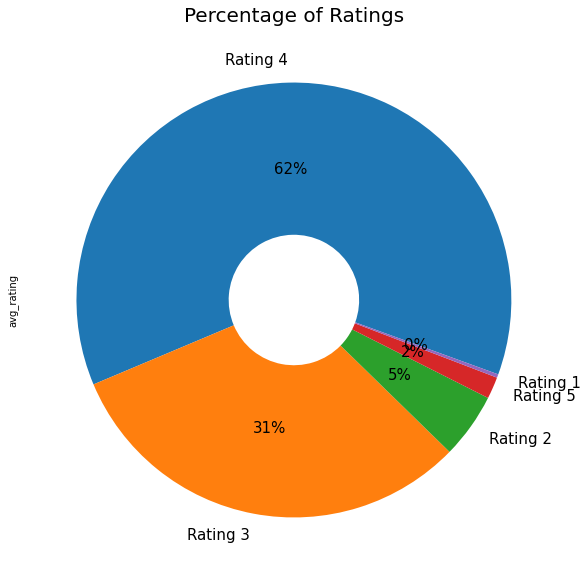

In [392]:
#Runs normalize counts of reviews by category in pie chart form
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
classification_set['avg_rating'].value_counts().plot(kind='pie', labels=['Rating 4', 'Rating 3', 'Rating 2', 'Rating 5', 'Rating 1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15}); 
#plt.savefig('rating_dist_donut.png')

> This is the breakdown of the ratings when they are rounded up to be classes. There is a large class imbalance that eventually moved me towards regression. I created a copy since I wanted to separate the rounded and non-rounded ratings.

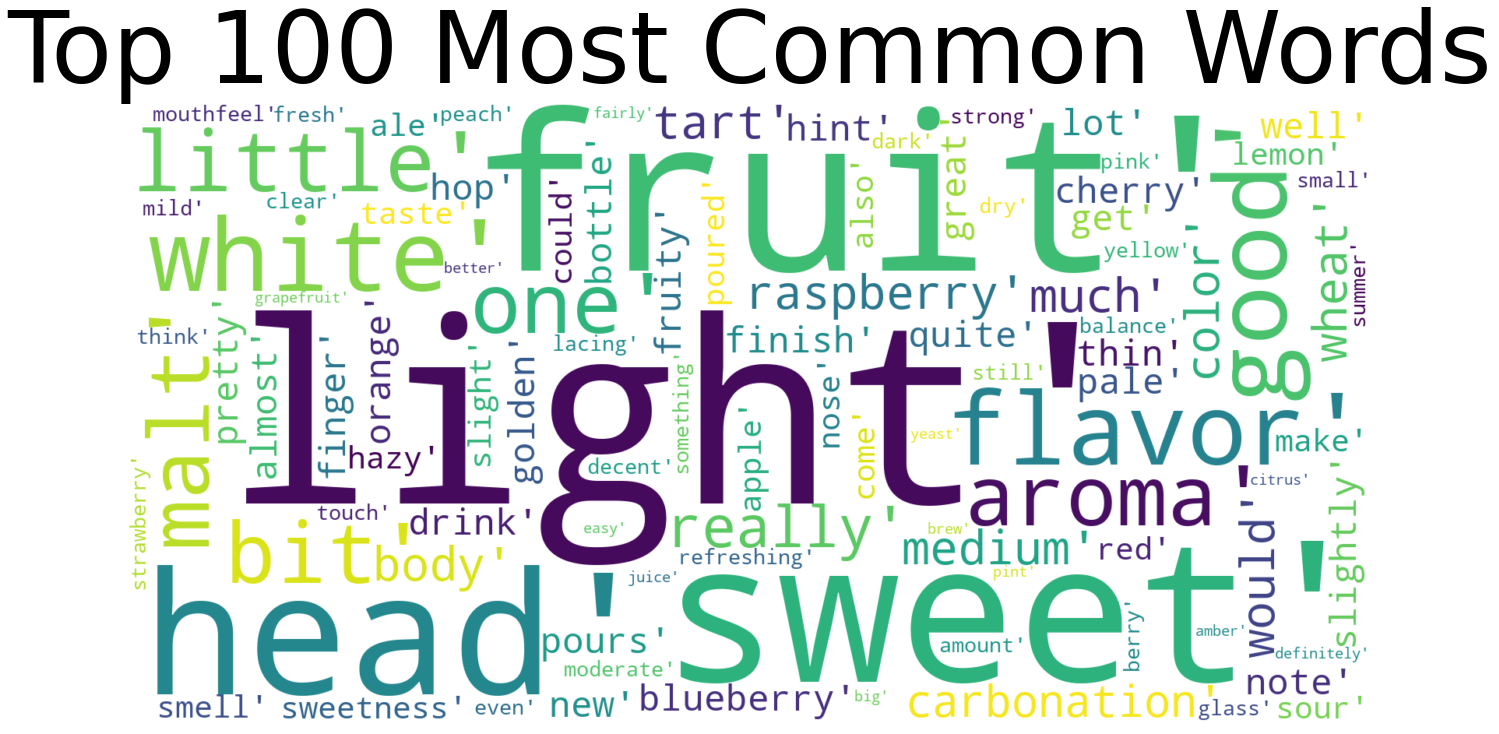

In [393]:
words = beer_df['clean_reviews']
allwords = []
for wordlist in words:
    allwords += wordlist
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.savefig('word_cloud_all.png')
plt.show();

>Beers with 'fruit', that are 'light', 'sweet', and with a good 'head' are trending towards being good indicators seeing as so many results are greater than 4.0

In [394]:
FreqDist(beer_df.loc[15, 'clean_reviews']).most_common(50)

[('belgian', 22),
 ('fruit', 21),
 ('little', 17),
 ('blackberry', 16),
 ('berry', 16),
 ('blueberry', 14),
 ('light', 13),
 ('head', 12),
 ('yeast', 12),
 ('sweet', 11),
 ('carbonation', 10),
 ('tart', 10),
 ('bit', 9),
 ('fruity', 9),
 ('bottle', 8),
 ('good', 8),
 ('would', 8),
 ('white', 8),
 ('medium', 8),
 ('strong', 8),
 ('really', 8),
 ('aroma', 8),
 ('come', 7),
 ('color', 7),
 ('red', 7),
 ('one', 7),
 ('spice', 7),
 ('well', 7),
 ('style', 7),
 ('flavor', 6),
 ('say', 6),
 ('finish', 6),
 ('finger', 6),
 ('pretty', 6),
 ('note', 6),
 ('think', 6),
 ('real', 6),
 ('brown', 5),
 ('slight', 5),
 ('fairly', 5),
 ('decent', 5),
 ('new', 5),
 ('high', 5),
 ('hint', 5),
 ('amber', 5),
 ('big', 5),
 ('poured', 4),
 ('foamy', 4),
 ('lacing', 4),
 ('around', 4)]

> This helps us to see the 50 most common words per each beer. 

C:\Users\GMoneyMan\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


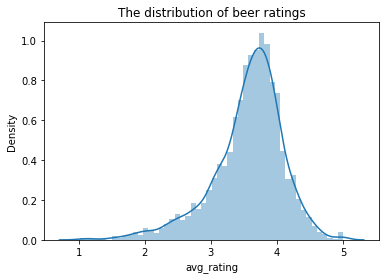

<Figure size 432x288 with 0 Axes>

In [471]:
sns.distplot(beer_df['avg_rating'])
#plt.xlabel('Rating')
#plt.ylabel('Count')
plt.title('The distribution of beer ratings')
plt.show()
plt.savefig('distrib_beer_ratings.png')

> Here we see a normal distribution of the data.

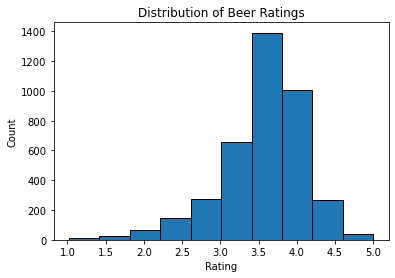

In [396]:
plt.hist(beer_df['avg_rating'], bins=10, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Beer Ratings')
plt.show()

> Here is another look at the data as a histogram, showing again the normal curve.

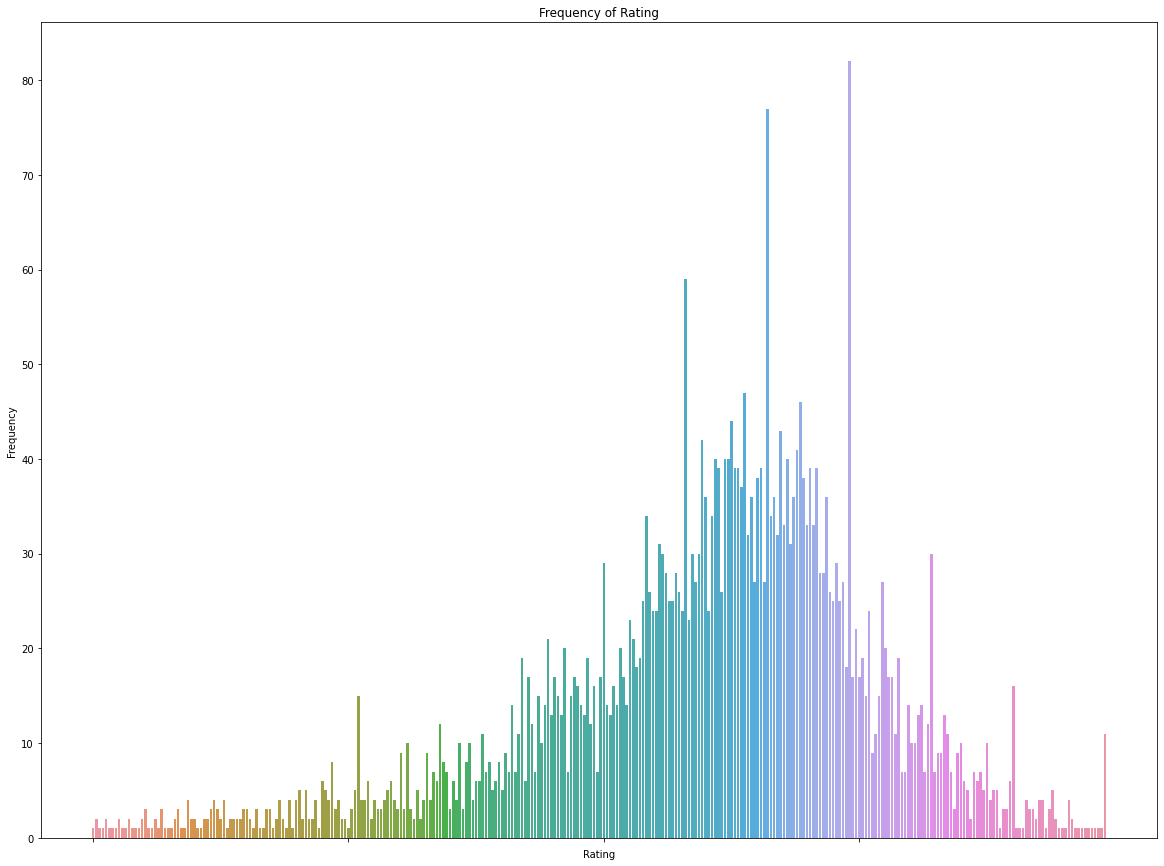

In [463]:
fig_dims=(20,15)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=beer_df['avg_rating'].value_counts(), x=beer_df['avg_rating'].value_counts().index, ax = ax)
ax.set(xlabel="Rating", ylabel = "Frequency")
ax.set_title("Frequency of Rating")
plt.locator_params(axis='x', nbins=4)
ax.set_xticklabels(ax.get_xticklabels('major'), rotation=45, horizontalalignment='right')
plt.show()

>I need to fix the x-axis.  This shows the ratings from 1 to 5 at 0.01 increments (there were no ratings less than 1). This shows the same kind of normal distributions we see above, but in the expanded look at the data we can see that a lot of the ratings spike at regular intervals like 2.00, 3.50, and so on. 

Text(0.5, 1.0, 'Distribution of Beers with X no. of Ratings ')

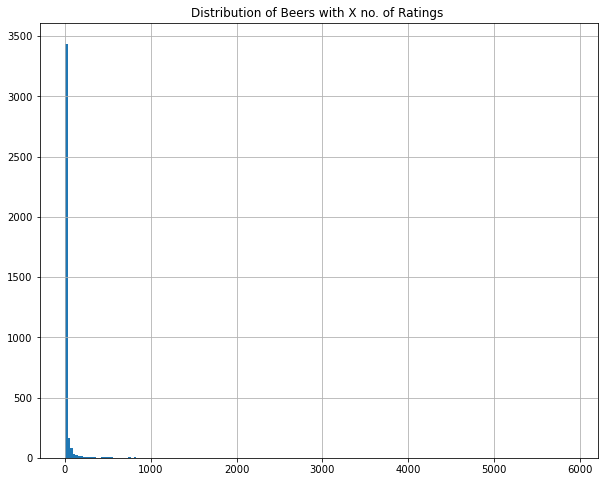

In [467]:
beer_df['no_ratings'].hist(figsize = (10,8), bins=200)
plt.xlabel= ("Number of Ratings")
plt.ylabel = ("Frequency")
plt.title('Distribution of Beers with X no. of Ratings')

> This shows the beers that have a certain number of ratings. As we see here most of the ratings are south of 100 per beer, while we have some outliers towards the right that have around 6,000 ratings for a single beer.

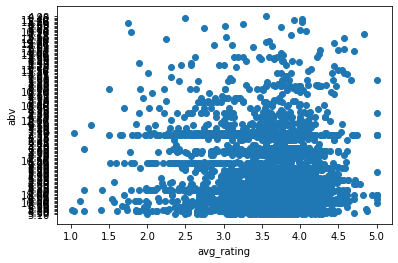

In [447]:
plt.scatter(beer_df['avg_rating'], beer_df['abv'])
plt.xlabel('avg_rating')
plt.ylabel('abv');

> Here when looking at the rating of beers against their abv (alcohol by volume) we see that most of the beers are on the lower end of the abv scale and as beers get stronger, there is a bit of a tapper to their frequency. 

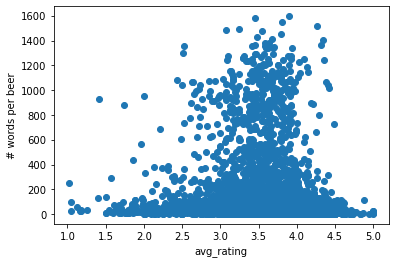

In [399]:
plt.scatter(beer_df['avg_rating'], beer_df['words'])
plt.xlabel('avg_rating')
plt.ylabel('# words per beer');

> Here we see a similar trend to the number of words being related to the quality of the rating. Very few words for the worst and best beers is a bit surprising as they would invoke the most emotion. 

In [117]:
#FreqDist(beer_df['clean_reviews']).most_common(50)

In [400]:
id2word = corpora.Dictionary(beer_df['clean_reviews'])

In [401]:
corpus = [id2word.doc2bow(text) for text in beer_df['clean_reviews']]

In [402]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, random_state=42,
                                             workers=5, passes=10)

In [403]:
print(lda_model.print_topics())

[(0, '0.016*"peach" + 0.016*"sweet" + 0.015*"orange" + 0.010*"head" + 0.009*"one" + 0.009*"flavor" + 0.008*"pumpkin" + 0.008*"little" + 0.008*"good" + 0.008*"light"'), (1, '0.097*"apricot" + 0.018*"russian" + 0.009*"light" + 0.008*"wheat" + 0.007*"new" + 0.006*"fruit" + 0.005*"sweet" + 0.005*"one" + 0.005*"honey" + 0.005*"good"'), (2, '0.008*"berry" + 0.008*"one" + 0.008*"fruit" + 0.007*"wheat" + 0.005*"sweet" + 0.005*"white" + 0.005*"raspberry" + 0.005*"flavor" + 0.005*"tart" + 0.005*"head"'), (3, '0.046*"cherry" + 0.017*"sweet" + 0.011*"fruit" + 0.011*"light" + 0.010*"red" + 0.010*"tart" + 0.010*"head" + 0.009*"flavor" + 0.008*"good" + 0.007*"bit"'), (4, '0.023*"light" + 0.015*"fruit" + 0.014*"flavor" + 0.013*"white" + 0.013*"head" + 0.011*"aroma" + 0.010*"good" + 0.009*"sweet" + 0.009*"color" + 0.008*"wheat"'), (5, '0.079*"blueberry" + 0.010*"flavor" + 0.009*"head" + 0.009*"one" + 0.009*"peanut" + 0.008*"light" + 0.008*"really" + 0.007*"much" + 0.007*"sweet" + 0.007*"fruit"'), (6, '

> I have designs to eventually get a recommendation system up and this LDA would be apart of that eventual model.

### Setting up Models

In [404]:
x = beer_df['naked_reviews']
y = beer_df['avg_rating']
z = classification_set['avg_rating']

In [405]:
#running train / test / split on naked reviews (str)
data_train, data_test, target_train, target_test = train_test_split(x, y, test_size=0.20, random_state=21)

>Here is the train-test-split for the data

In [406]:
tfidf = TfidfVectorizer(max_df = .9, min_df=.1)

>I use a max of 0.9 and a min of 0.1 to get rid of words that show up constantly (low value) and words that show up once (words that probably have little importance).

In [407]:
tfidf_data_train = tfidf.fit_transform(data_train)
tfidf_data_test = tfidf.transform(data_test)

print(tfidf_data_train.shape)
print(tfidf_data_test.shape)

(3105, 236)
(777, 236)


>Here we check the shape of the data to make sure they have similar number of columns. It is also important that there aren't more columns than rows or else it breaks

In [480]:
#print(tfidf_data_train)

In [477]:
print(tfidf.vocabulary_)

{'poured': 164, 'clear': 45, 'dark': 53, 'white': 228, 'head': 103, 'quickly': 168, 'hint': 106, 'juice': 112, 'tart': 209, 'think': 217, 'probably': 167, 'brewed': 33, 'sugar': 201, 'slightly': 186, 'color': 47, 'inch': 110, 'big': 24, 'touch': 221, 'light': 124, 'moderate': 143, 'make': 134, 'solid': 191, 'lemon': 123, 'would': 232, 'get': 88, 'summer': 202, 'ale': 4, 'quite': 169, 'actually': 1, 'much': 147, 'thing': 216, 'drink': 58, 'hazy': 102, 'golden': 94, 'medium': 137, 'aroma': 12, 'sweet': 205, 'nothing': 153, 'well': 226, 'made': 133, 'crisp': 52, 'sure': 204, 'fruit': 85, 'even': 67, 'artificial': 14, 'pours': 165, 'amber': 9, 'small': 187, 'soft': 190, 'kind': 113, 'somewhat': 193, 'fairly': 71, 'nose': 151, 'hop': 108, 'new': 149, 'back': 16, 'one': 154, 'looking': 129, 'got': 96, 'pale': 159, 'seems': 181, 'citrus': 43, 'almost': 5, 'malt': 135, 'really': 173, 'yellow': 234, 'lot': 130, 'going': 92, 'le': 118, 'hit': 107, 'something': 192, 'good': 95, 'mild': 139, 'come

> Here we can see the vocabulary the vectorizer learned from the corpus

In [408]:
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 43.96135265700483
Percentage of columns containing 0: 0.813723081961844


>Looking at the distribution of the words in the data we see that 81% of the columns have a 0 value and that the average number of words in a non-zero article is about 44 words.

### Regression Models

#### XGBoost Regressor (basic)

> Starting with a grid search for XGBoost

In [518]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, .04, 0.05, 0.06, .07], #so called `eta` value
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [3, 4, 5],
              'silent': [1],
              'subsample': [.05, 0.06, 0.7],
              #'colsample_bytree': [.03, .04, 0.05, 0.06, 0.7],
              'n_estimators': [10, 100, 500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

tqdm(xgb_grid.fit(tfidf_data_train,
         target_train))

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.6min finished


[21:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-518-722fb81ff9b5>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm(xgb_grid.fit(tfidf_data_train,


0.1940883500050929
{'learning_rate': 0.04, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [515]:
# ''' the first one is without gridsearch and its not bad'''
# xgb = XGBRegressor(objective ='reg:linear',
#                   n_estimators = 9, seed = 124, n_jobs= -1)

xgb = XGBRegressor(objective = 'reg:linear', n_estimators =500, seed = 124, n_jobs = -1, 
                   learning_rate = 0.04, max_depth = 5, min_child_weight = 5, colsample_bytree = 0.7,
                  subsample = 0.7)
xgb.fit(tfidf_data_train, target_train)

[20:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[20:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=124, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=124, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [516]:
xgb_train_pred = xgb.predict(tfidf_data_train)
xgb_test_pred = xgb.predict(tfidf_data_test)

In [517]:
xgb_train_rmse = np.sqrt(metrics.mean_squared_error(target_train, xgb_train_pred))
xgb_test_rmse = np.sqrt(metrics.mean_squared_error(target_test, xgb_test_pred))
print('Training: ', (xgb_train_rmse), "vs. Testing: ", (xgb_test_rmse))

Training:  0.30747709406258866 vs. Testing:  0.46576745542080017


> Okay but over fit compared to Linear Regression or Ridge, and not as bad as others.

#### LinearRegression (basic)

In [412]:
lm = linear_model.LinearRegression()
lm = lm.fit(tfidf_data_train, target_train)

In [413]:
lm_train_pred = lm.predict(tfidf_data_train)
lm_test_pred = lm.predict(tfidf_data_test)

In [414]:
train_rmse = np.sqrt(metrics.mean_squared_error(target_train, lm_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(target_test, lm_test_pred))

print('Training: ', (train_rmse), "vs. Testing: ", (test_rmse))

Training:  0.431691431233888 vs. Testing:  0.4570927212624957


> Very solid model where it is low and isn't over / underfit

#### RandomForest Regressor (basic)

In [415]:
rf = RandomForestRegressor(random_state = 21)#max_depth=10,max_features=10)
rf.fit(tfidf_data_train, target_train)

RandomForestRegressor(random_state=21)

In [416]:
rf_train_pred = rf.predict(tfidf_data_train)
rf_test_pred = rf.predict(tfidf_data_test)

In [417]:
rf_train_rmse = np.sqrt(metrics.mean_squared_error(target_train, rf_train_pred))
rf_test_rmse = np.sqrt(metrics.mean_squared_error(target_test, rf_test_pred))
print('Training: ', (rf_train_rmse), "vs. Testing: ", (rf_test_rmse))

Training:  0.236378869091903 vs. Testing:  0.4737897600156327


> Good but more overfit than I would like

#### Bayesian Ridge (basic)

In [418]:
bayridge = linear_model.BayesianRidge()
bayridge.fit(tfidf_data_train.toarray(),target_train)

BayesianRidge()

In [419]:
br_train_pred = bayridge.predict(tfidf_data_train)
br_test_pred = bayridge.predict(tfidf_data_test)

In [420]:
br_train_rmse = np.sqrt(metrics.mean_squared_error(target_train, br_train_pred))
br_test_rmse = np.sqrt(metrics.mean_squared_error(target_test, br_test_pred))
print('Training: ', (br_train_rmse), "vs. Testing: ", (br_test_rmse))

Training:  0.43483254352703543 vs. Testing:  0.44920929828235506


> Slightly not as good in the training, but better in the testing than the Linear Regression

#### SVM (basic)

In [421]:
svm_reg=svm.SVR()
svm_reg.fit(tfidf_data_train, target_train)

SVR()

In [422]:
sv_train_pred = svm_reg.predict(tfidf_data_train)
sv_test_pred = svm_reg.predict(tfidf_data_test)

In [423]:
sv_train_rmse = np.sqrt(metrics.mean_squared_error(target_train, sv_train_pred))
sv_test_rmse = np.sqrt(metrics.mean_squared_error(target_test, sv_test_pred))
print('Training: ', (sv_train_rmse), "vs. Testing: ", (sv_test_rmse))

Training:  0.2469368708956416 vs. Testing:  0.44898115343774503


> Overfit like the RandomForest

#### KNN (basic)

In [424]:
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(tfidf_data_train,target_train)

KNeighborsRegressor()

In [425]:
knn_train_pred=knn.predict(tfidf_data_train)
knn_test_pred=knn.predict(tfidf_data_test)

In [426]:
knn_train_rmse = np.sqrt(metrics.mean_squared_error(target_train, knn_train_pred))
knn_test_rmse = np.sqrt(metrics.mean_squared_error(target_test, knn_test_pred))
print('Training: ', (knn_train_rmse), "vs. Testing: ", (knn_test_rmse))

Training:  0.44499500150985977 vs. Testing:  0.5231047201684843


> Okay results but not as good as Linear Regression or Ridge

### Classification Models

In [355]:
#running train / test / split on naked reviews (str)
data_train_c, data_test_c, target_train_c, target_test_c = train_test_split(x, z, test_size=0.20, random_state=21)

In [356]:
tfidf_data_train_c = tfidf.fit_transform(data_train_c)
tfidf_data_test_c = tfidf.transform(data_test_c)

print(tfidf_data_train_c.shape)
print(tfidf_data_test_c.shape)

(3105, 236)
(777, 236)


#### RandomForestClassifier (basic)

In [357]:
rf = RandomForestClassifier(random_state = 21)#max_depth=10,max_features=10)
rf.fit(tfidf_data_train_c, target_train_c)

RandomForestClassifier(random_state=21)

In [358]:
rf_test_pred = rf.predict(tfidf_data_test_c)

In [359]:
rf_recall = recall_score(target_test_c, rf_test_pred, average='weighted')
rf_acc_score = accuracy_score(target_test_c, rf_test_pred)
rf_f1_score = f1_score(target_test_c, rf_test_pred, average='weighted')
print('Random Forest with Lemmatized Features:')
print(3*'-----')

print('Recall: {:.4}'.format(rf_recall))
print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Lemmatized Features:
---------------
Recall: 0.668
Testing Accuracy: 0.668
F1 Score: 0.6086


#### XGBoost Classifier (basic)

In [360]:
xgboost = XGBClassifier()
xgboost.fit(tfidf_data_train_c, target_train_c)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [361]:
xgb_train_pred = xgboost.predict(tfidf_data_train_c)
xgb_test_pred = xgboost.predict(tfidf_data_test_c)

In [362]:
xgb_recall = recall_score(target_test_c, xgb_test_pred, average='weighted')
xgb_acc_score = accuracy_score(target_test_c, xgb_test_pred)
xgb_f1_score = f1_score(target_test_c, xgb_test_pred, average='weighted')

print('XG Boost with Lemmatized Features:')
print(3*'-----')

print('Recall: {:.4}'.format(xgb_recall))

print("Testing Accuracy: {:.4}".format(xgb_acc_score))
print("F1 Score: {:.4}".format(xgb_f1_score))

XG Boost with Lemmatized Features:
---------------
Recall: 0.6628
Testing Accuracy: 0.6628
F1 Score: 0.6262


>At first I used classification to engage with the classes of the ratings (1, 2, 3, 4, and 5, which I established by rounding prior to the TTS) but after looking at the class imbalance it didn't seem very good at giving meaningful separation of the the data. Afterwards I turned towards Regression models to help better get a continuous scale of the information. I placed it here so that it doesn't disrupt the flow of the notebook. Also this section needs to be run before the first visualization can work.